# DIY tutorial

As we learned from the basic tutorial, in WannierBerri  calculations are done by [`Calculator`](https://wannier-berri.org/docs/calculators.html#wannierberri.calculators.Calculator)s. In this tutorial we will se how to create our own calculators. 

As an example let's consider anomalous Nernst conductivity ([Xiao et al. 2006 ](https://doi.org/10.1103/PhysRevLett.97.026603) ). In the zero-temperature limit $\alpha_{\alpha\beta}^{\rm ANE}$ may be obtained from
   AHC $\sigma_{\alpha\beta}(\epsilon)^{\rm AHE}$ evaluated over a
   dense grid of Fermi levels $\epsilon$

$$
       \alpha_{\alpha\beta}^{\rm ANE}=-\frac{1}{e}\int d\varepsilon \frac{\partial f}{\partial\varepsilon}\sigma_{\alpha\beta}(\varepsilon)\frac{\varepsilon-\mu}{T}, \label{eq:ane} \tag{1}
$$

   where $f(\varepsilon)=1/\left(1+e^\frac{\varepsilon-\mu}{k_{\rm B}T}\right)$ and the AHC is defined as a Fermi-sea integral of Berry curvature

\begin{equation}
\sigma^{\rm AHC}_{xy} = -\frac{e^2}{\hbar} \sum_n \int\frac{d\mathbf{k}}{(2\pi)^3} \Omega^n_\gamma f(\epsilon_n)
\label{eq:ahc}\tag{2}
\end{equation}

   
   In the zero-temperature limit it reduced to 
   $$
   \alpha_{\alpha\beta}^{\rm ANE} \propto \frac{\partial \sigma_{\alpha\beta}(\varepsilon)}{\partial \varepsilon}
   \propto \int\frac{d\mathbf{k}}{(2\pi)^3} \Omega^n_\gamma f'(\epsilon_n) \tag{3}\label{eq:ane-ahc}
   $$
   
   Where we omit the dimensional factor for simplicity.
   
   **Thus, there are two ways of calculating ANE** : 
   * via eq (\ref{eq:ane-ahc}) 
   * via eq (\ref{eq:ane}) 
   
   let's try eq (\ref{eq:ane-ahc}) first, because AHC is already implemented
   
   **Warning** : this is an advanced tutorial. You something may not work from first try, you need to work with documentation to resolve the problem, but do not hesitate to ask the TA if you cannot. 
  

In [1]:
# Preliminary 

# Set environment variables - not mandatory but recommended if you use Parallel()
#import os
#os.environ['OPENBLAS_NUM_THREADS'] = '1' 
#os.environ['MKL_NUM_THREADS'] = '1'


import wannierberri as wberri
import wannierberri.models
print (f"Using WannierBerri version {wberri.__version__}")
import numpy as np
import scipy
import matplotlib.pyplot as plt
from termcolor import cprint

#  This block is needed if you run this cell for a second time
#  because one cannot initiate two parallel environments at a time
try:
    parallel.shutdown()   
except NameError:
    pass

# Chiose one of the options:

parallel = wberri.Parallel(num_cpus=2)
#parallel = wberri.Parallel()  # automatic detection 
#parallel = wberri.Serial()



Using WannierBerri version 0.13.5


2023-08-12 02:20:26,671	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8268 


In [2]:
# Instead of Wannier functions, we work with a Hlldane model here https://wannier-berri.org/docs/models.html

model=wberri.models.Haldane_ptb()
system = wberri.System_PythTB(model)


R=0 found at position(s) [[3]]
NOT using ws_dist
Number of wannier functions: 2
Number of R points: 7
Recommended size of FFT grid [3 3 1]
Reading the system from PythTB finished successfully


## anomalous Hall conductivity

Now, let's evaluate the AHC on a grid of Ef-points, and then take a derivtive


In [3]:
calculators = {}
Efermi = np.linspace(-3,3,21)
# Set a grid 
grid = wberri.Grid(system, length=30 )   # length [ Ang] ~= 2*pi/dk

calculators ["ahc"] = wberri.calculators.static.AHC(Efermi=Efermi,tetra=False,kwargs_formula={"external_terms":False})

result_run_ahc = wberri.run(system,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            adpt_num_iter=0,
            fout_name='Fe',
            restart=False,
            file_Klist="Klist_ahc.pickle",  # needed to restart a calculation in future
            print_Kpoints=False
            )




determining grids from NK=None (<class 'NoneType'>), NKdiv=None (<class 'NoneType'>), NKFFT=None (<class 'NoneType'>)
length=30 was converted into NK=[35 35 30]
Minimal symmetric FFT grid :  [3 3 1]
The grids were set to NKdiv=[7 7 1], NKFFT=[5 5 1], NKtot=[35 35  1]
Anomalous Hall conductivity (:math:`s^3 \cdot A^2 / (kg \cdot m^3) = S/m`)

        | With Fermi sea integral Eq(11) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`_
        | Output: :math:`O = -e^2/\hbar \int [dk] \Omega f`
        | Instruction: :math:`j_\alpha = \sigma_{\alpha\beta} E_\beta = \epsilon_{\alpha\beta\delta} O_\delta E_\beta`

Grid is regular
The set of k points is a Grid() with NKdiv=[7 7 1], NKFFT=[5 5 1], NKtot=[35 35  1]
generating K_list
Done in 0.0007460117340087891 s 
excluding symmetry-equivalent K-points from initial grid
Done in 0.002871274948120117 s 
Done in 0.0028917789459228516 s 
K_list contains 49 Irreducible points(100.0%) out of initial 7x7x1=49 grid
Done, sum of weights:1.0

In [4]:
!ls

Fe-ahc_iter-0000.dat  Klist_ahc.pickle
Fe-ahc_iter-0000.npz  tutorial-wb-DIY.ipynb


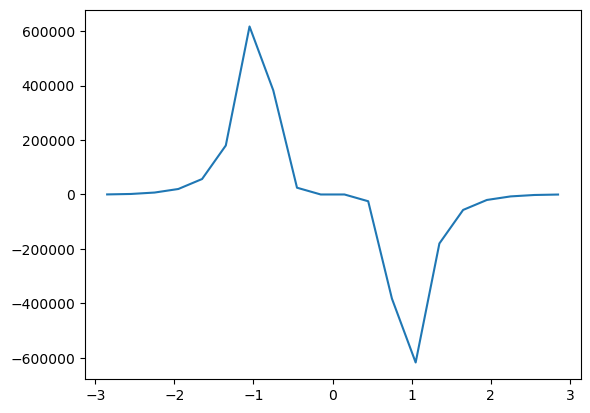

In [5]:
# taking derivative and plotting

ef = result_run_ahc.results["ahc"].Energies[0]
ahc_z = result_run_ahc.results["ahc"].data[:,2]

# take the derivative
d_ef=ef[1]-ef[0]
d_ahc_z = (ahc_z[1:]-ahc_z[:-1])/d_ef
efnew = (ef[1:]+ef[:-1])/2

plt.plot(efnew, d_ahc_z)






## Look into documentation

Look into documentation to see how the AHC calculator is defined : look for "Calculator" on
https://docs.wannier-berri.org and press the "source" link.

One can see that it is based on the StaticCalculator, and only redefines the `__init__` method. 
Namely, it redefines formula that stands under the integral (Berry curvature) and `fder=0` meaning that the formula is weighted by the 0th derivative of the Fermi distribution.

copy the definition of AHC calculator and redefine the and below and define the __init__ class


(hint : leave the factor the same, for simplicity)
(hint : formula shouldbe imported from wannierberri.formula.covariant.DerOmega ) 



In [6]:
from wannierberri.calculators.static import StaticCalculator
from wannierberri.formula.covariant import Omega
from wannierberri import __factors as factors

class ANE(StaticCalculator):
    
    ........
        
        

SyntaxError: invalid syntax (1443802983.py, line 7)

### Evaluate ANE  using the new calculator and plot the result



In [1]:
# insert the needed code below

calculators = {}
Efermi = np.linspace(12,13,101)
# Set a grid 
grid = wberri.Grid(system, length=50 )   # length [ Ang] ~= 2*pi/dk

calculators ["ane"] = ANE(Efermi=Efermi,tetra=True)

result_run_ane = wberri.run(system,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            adpt_num_iter=0,
            fout_name='Fe',
            restart=False,
           # file_Klist="Klist_ahc.pickle"  # needed to restart a calculation in future
            )



NameError: name 'np' is not defined

In [2]:

ef = result_run_ane.results["ane"].Energies[0]
ane_z = result_run_ane.results["ane"].dataSmooth[:,2]


plt.scatter(efnew,d_ahc_z)
plt.plot(ef, ane_z)
plt.show()

NameError: name 'result_run_ane' is not defined

## Questions: 

1. Make the k-points or Efermi denser. Will the agreement improve?

2. we calculated the AHC and ANE with zero refinement iterations, and the results matched well (or at least they should). If we calculate them separately, but with some refinement iterations, will the results match?

3. What if we use refinement itrations and run the two calculations together, in one `run()` call ?

## FormulaProduct

Look at the definition of erryDipole_FermiSurf

https://wannier-berri.org/_modules/wannierberri/calculators/static.html


It evaluates 

\begin{equation}
D_{ab} =\sum_n \int\frac{d\mathbf{k}}{(2\pi)^3} v_a\Omega^n_b f(\epsilon_n)
\label{eq:ahc}\tag{2}
\end{equation}

also look at definition of the Feormula https://wannier-berri.org/docs/formula.html 

you can see that it is base on a FormulaProduct.  Essentially, by analogy you may define any tensor, e.g. 

$$
\sum_n \int\frac{d\mathbf{k}}{(2\pi)^3} v_a\Omega^n_b v_c f''(\epsilon_n)
$$

i.e. product of several quantities weighted by rge second derivative of Fermi distribution. You may write any analogous formula, if you want. Try to define corresponding FormulaProduct and StaticCalculator classes, and try to evaluate them. 



## Problem :


 try to prove (analytically and numerically) that 

$$
\sum_n \int\frac{d\mathbf{k}}{(2\pi)^3} \partial_a \partial_b \partial_c \epsilon_{n\mathbf{k}} f(\epsilon_{n\mathbf{k}}) \propto \sum_n \int\frac{d\mathbf{k}}{(2\pi)^3} \partial_a \epsilon_{n\mathbf{k}}  \partial_b \epsilon_{n\mathbf{k}}  \partial_c \epsilon_{n\mathbf{k}} f''(\epsilon_{n\mathbf{k}})
$$ 

and tell me what is the factor missing?


** Have fun ! **